# ARIMA

### Libraries

In [1]:
# import libraries

import joblib

import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

### Data

In [2]:
# load negative, neutral and positive time series

negative_reviews_per_month = pd.read_csv('features/negative_reviews_per_month.csv', index_col=0, parse_dates=True)
neutral_reviews_per_month = pd.read_csv('features/neutral_reviews_per_month.csv', index_col=0, parse_dates=True)
positive_reviews_per_month = pd.read_csv('features/positive_reviews_per_month.csv', index_col=0, parse_dates=True)

In [3]:
# load sentiment time series

sentiment_per_month = pd.read_csv('features/sentiment_per_month.csv', index_col=0, parse_dates=True)

In [4]:
# load categories time series

sentiment_restaurants_per_month = pd.read_csv('features/sentiment_restaurants_per_month.csv', index_col=0, parse_dates=True)
sentiment_nightlife_per_month = pd.read_csv('features/sentiment_nightlife_per_month.csv', index_col=0, parse_dates=True)
sentiment_breakfast_brunch_per_month = pd.read_csv('features/sentiment_breakfast_brunch_per_month.csv', index_col=0, parse_dates=True)

### Stationarity

In [5]:
def stationarity_adf(time_series, extra_info=False):
    '''
    Check stationarity with Augmented Dickey-Fuller test
    '''
    adf_test = adfuller(time_series, autolag='AIC', regression='ct')
    print("ADF Test Results")
    print(f"p-value: {adf_test[1]}")
    if extra_info:
        print("Null Hypothesis: The series has a unit root (non-stationary)")
        print(f"ADF Statistic: {adf_test[0]}")
        print(f"Used Lags: {adf_test[2]}")
        print(f"Number of Observations: {adf_test[3]}")
        print(f"Critical Values: {adf_test[4]}")
        print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")
    is_stationary = adf_test[1] < 0.05
    print(f"Is the series stationary? {is_stationary}")
    print()

#### Sentiment

ADF Test Results
p-value: 2.3845342535675003e-13
Is the series stationary? True



<Axes: title={'center': 'Differenced Sentiment Residuals'}, xlabel='date'>

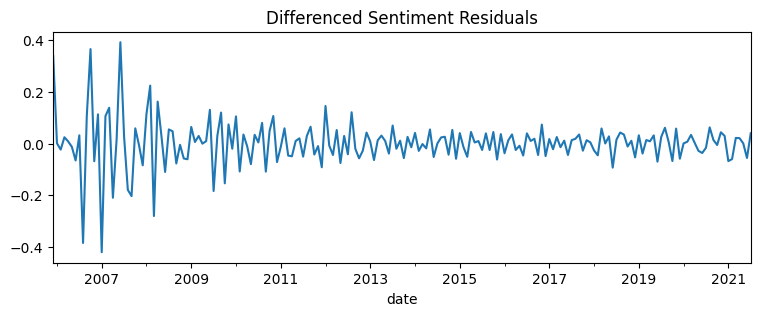

In [6]:
# differencing sentiment to make it stationary

sentiment_residual = sentiment_per_month['residual'].dropna()
sentiment_residual_diff = sentiment_residual.diff().dropna()

stationarity_adf(sentiment_residual_diff)

sentiment_residual_diff.plot(figsize=(9, 3), title='Differenced Sentiment Residuals')

#### Category sentiment

ADF Test Results
p-value: 5.8352230392082015e-12
Is the series stationary? True



<Axes: title={'center': 'Differenced Restaurant Sentiment Residuals'}, xlabel='date'>

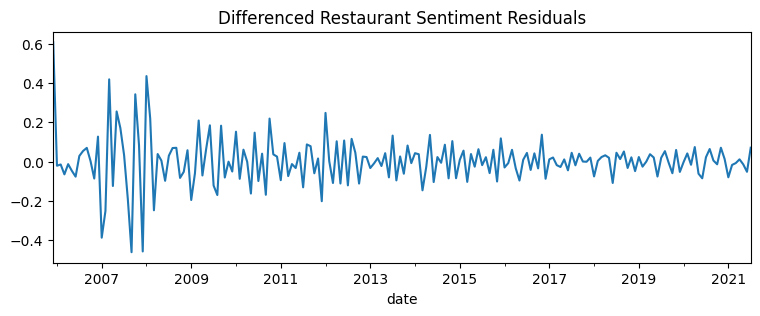

In [7]:
# differencing restaurant sentiment to make it stationary

restaurant_residual = sentiment_restaurants_per_month['residual'].dropna()
restaurant_residual_diff = restaurant_residual.diff().dropna()

stationarity_adf(restaurant_residual_diff)

restaurant_residual_diff.plot(figsize=(9, 3), title='Differenced Restaurant Sentiment Residuals')

ADF Test Results
p-value: 1.2298800953058604e-09
Is the series stationary? True



<Axes: title={'center': 'Differenced Nightlife Sentiment Residuals'}, xlabel='date'>

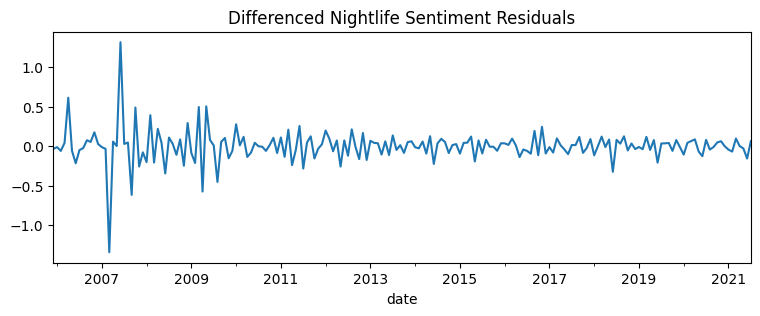

In [8]:
# differencing nightlife sentiment to make it stationary

nightlife_residual = sentiment_nightlife_per_month['residual'].dropna()
nightlife_residual_diff = nightlife_residual.diff().dropna()

stationarity_adf(nightlife_residual_diff)

nightlife_residual_diff.plot(figsize=(9, 3), title='Differenced Nightlife Sentiment Residuals')

ADF Test Results
p-value: 6.54409052209537e-14
Is the series stationary? True



<Axes: title={'center': 'Differenced Breakfast & Brunch Sentiment Residuals'}, xlabel='date'>

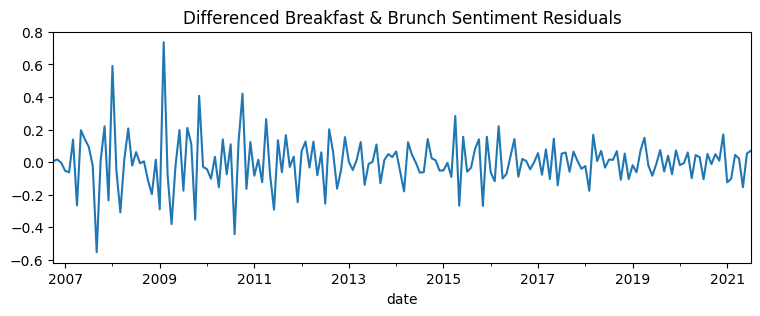

In [9]:
# differencing breakfast & brunch sentiment to make it stationary

breakfast_brunch_residual = sentiment_breakfast_brunch_per_month['residual'].dropna()
breakfast_brunch_residual_diff = breakfast_brunch_residual.diff().dropna()

stationarity_adf(breakfast_brunch_residual_diff)

breakfast_brunch_residual_diff.plot(figsize=(9, 3), title='Differenced Breakfast & Brunch Sentiment Residuals')

### Autocorrelation and partial autocorrelation

In [10]:
def acf_and_pacf_plots(time_series, title='ACF and PACF Plots'):
    '''
    Plot ACF and PACF plots for time series data
    '''
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    plot_acf(time_series, ax=axes[0], lags=40)
    plot_pacf(time_series, ax=axes[1], lags=40)

    axes[0].set_title('ACF')
    axes[1].set_title('PACF')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

#### Sentiment

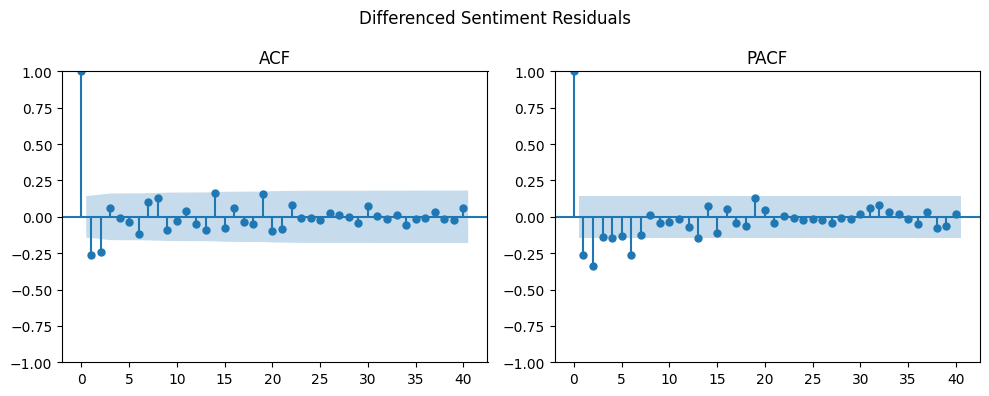

In [11]:
# ACF and PACF plots for sentiment per month

acf_and_pacf_plots(sentiment_residual_diff, title='Differenced Sentiment Residuals')

#### Category sentiment

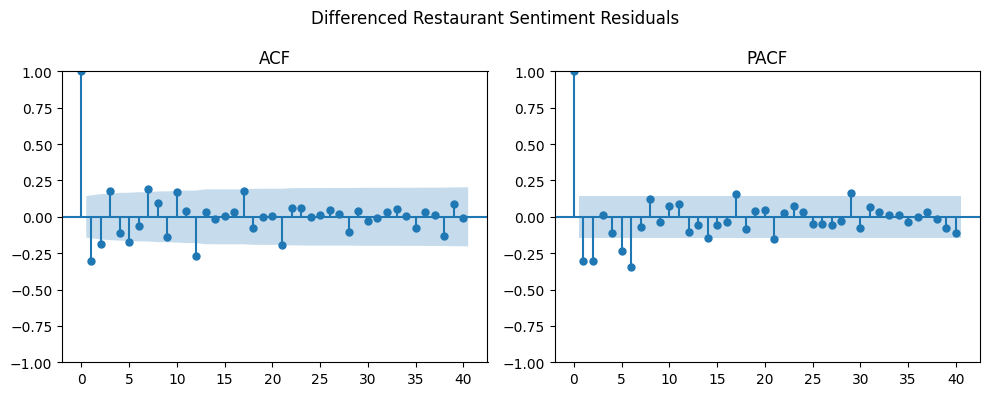

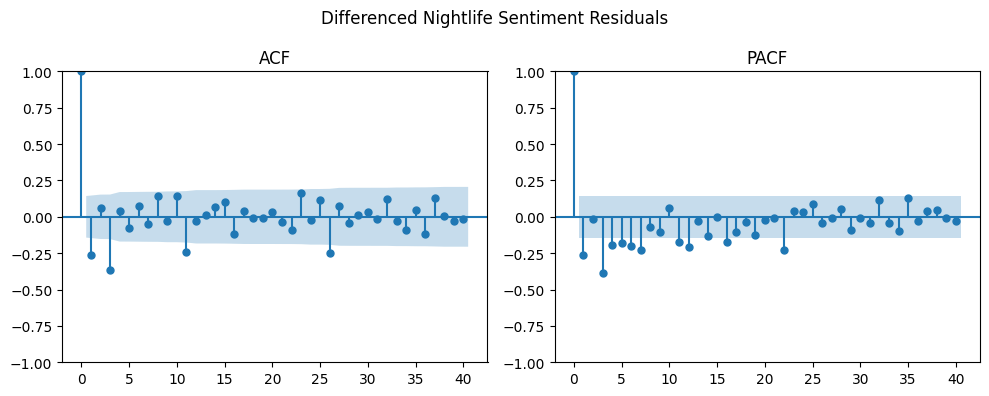

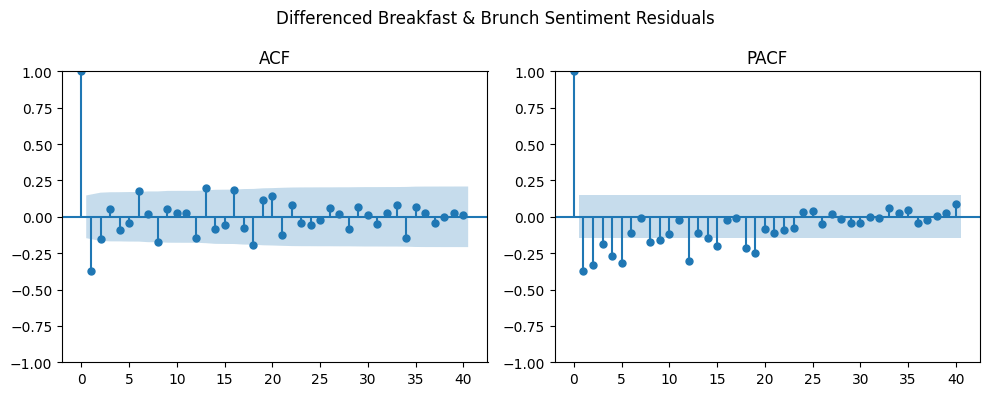

In [12]:
# ACF and PACF plots for categories sentiment per month

acf_and_pacf_plots(restaurant_residual_diff, title='Differenced Restaurant Sentiment Residuals')
acf_and_pacf_plots(nightlife_residual_diff, title='Differenced Nightlife Sentiment Residuals')
acf_and_pacf_plots(breakfast_brunch_residual_diff, title='Differenced Breakfast & Brunch Sentiment Residuals')

### ARMA modelling

In [13]:
# order values

p_values = range(0, 3)
q_values = range(0, 3)

In [14]:
def fit_arma_model(time_series, p_values=p_values, q_values=q_values):
    '''
    Fit ARMA model to time series data using AICc
    '''
    best_aic = float("inf")
    best_order = None
    best_model = None
    for p in p_values:
        for q in q_values:
            try:
                model = ARIMA(time_series, order=(p, 0, q))
                model_fit = model.fit()
                aic = model_fit.aic
                print(f'ARMA({p},{q}) - AIC:{aic}')
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, q)
                    best_model = model_fit
            except Exception as e:
                print(f'Error fitting ARMA({p},{q}): {e}')
                continue
    print(f'Best ARMA model order: {best_order} with AIC: {best_aic}')
    return best_model

#### Sentiment

In [15]:
# fit model

sentiment_model = fit_arma_model(sentiment_residual_diff)

c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Pr

ARMA(0,0) - AIC:-369.88914628347686
ARMA(0,1) - AIC:-458.99160893459106


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utilizad

ARMA(0,2) - AIC:-463.8682771831461
ARMA(1,0) - AIC:-382.7870726527942
ARMA(1,1) - AIC:-461.04720912685286


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utilizad

ARMA(1,2) - AIC:-465.5337779231438
ARMA(2,0) - AIC:-406.44119665405805


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizad

ARMA(2,1) - AIC:-469.3290745301692
ARMA(2,2) - AIC:-459.9937352013561
Best ARMA model order: (2, 1) with AIC: -469.3290745301692


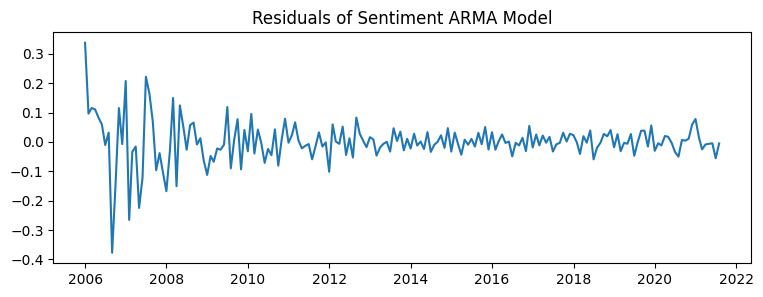

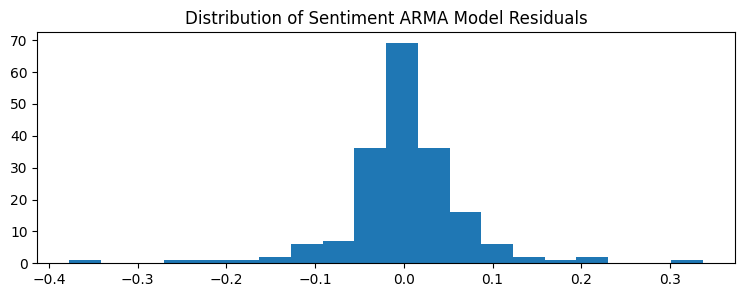

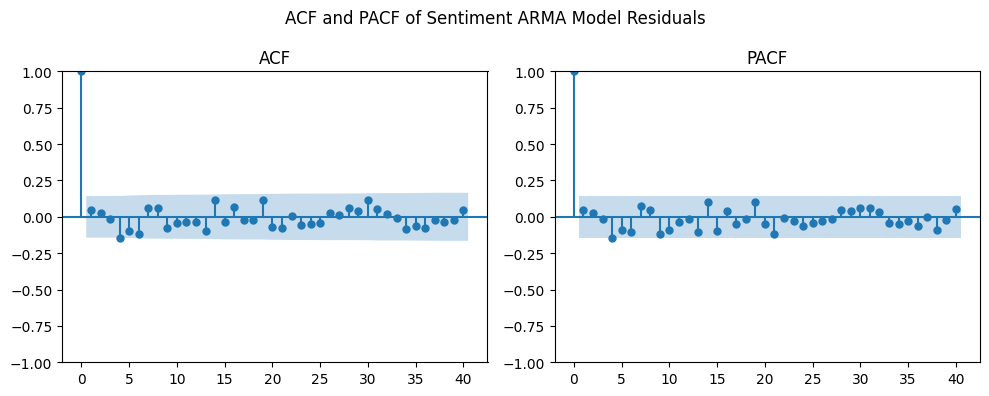

In [16]:
# model residuals

plt.figure(figsize=(9, 3))
plt.plot(sentiment_model.resid)
plt.title('Residuals of Sentiment ARMA Model')
plt.show()

plt.figure(figsize=(9, 3))
plt.hist(sentiment_model.resid, bins=20)
plt.title('Distribution of Sentiment ARMA Model Residuals')
plt.show()

acf_and_pacf_plots(sentiment_model.resid, title='ACF and PACF of Sentiment ARMA Model Residuals')

In [17]:
# save model

joblib.dump(sentiment_model, 'models/sentiment_arma.pkl')

['models/sentiment_arma.pkl']

#### Restaurant sentiment

In [18]:
# fit model

restaurant_model = fit_arma_model(restaurant_residual_diff)

c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Pr

ARMA(0,0) - AIC:-253.2836821612837
ARMA(0,1) - AIC:-342.8516294315527


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


ARMA(0,2) - AIC:-345.1014786434611
ARMA(1,0) - AIC:-272.49344703603043


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Pr

ARMA(1,1) - AIC:-343.88514256398554


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


ARMA(1,2) - AIC:-344.9125149470649
ARMA(2,0) - AIC:-295.05041053341347


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Pr

ARMA(2,1) - AIC:-345.70915942436795


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


ARMA(2,2) - AIC:-345.105729523592
Best ARMA model order: (2, 1) with AIC: -345.70915942436795


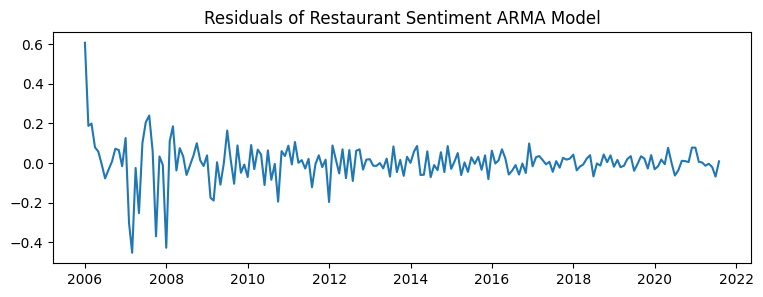

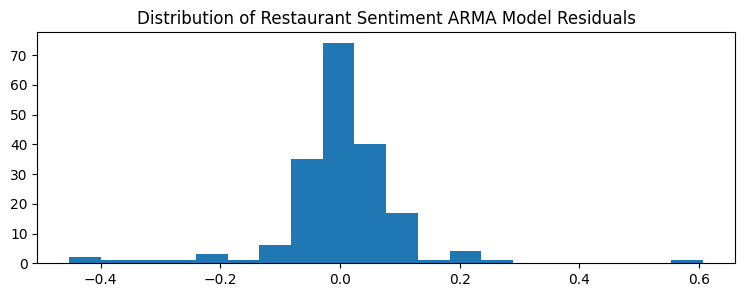

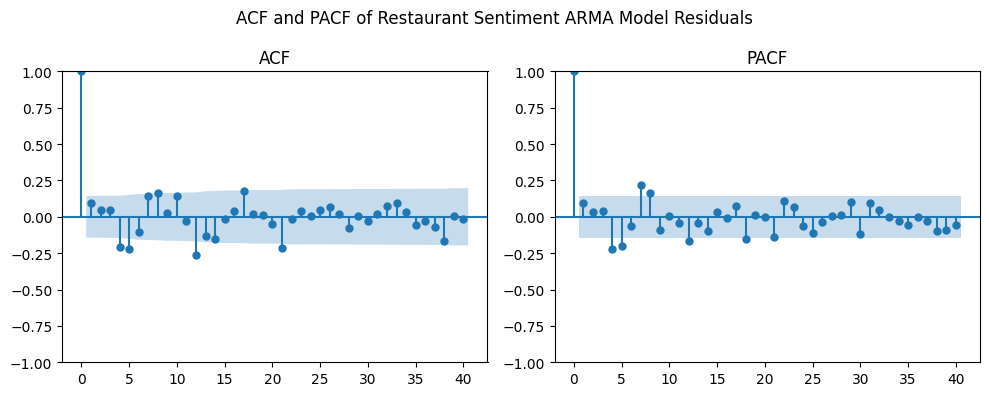

In [19]:
# model residuals

plt.figure(figsize=(9, 3))
plt.plot(restaurant_model.resid)
plt.title('Residuals of Restaurant Sentiment ARMA Model')
plt.show()

plt.figure(figsize=(9, 3))
plt.hist(restaurant_model.resid, bins=20)
plt.title('Distribution of Restaurant Sentiment ARMA Model Residuals')
plt.show()

acf_and_pacf_plots(restaurant_model.resid, title='ACF and PACF of Restaurant Sentiment ARMA Model Residuals')

In [20]:
# save model

joblib.dump(restaurant_model, 'models/restaurant_arma.pkl')

['models/restaurant_arma.pkl']

#### Nightlife sentiment

In [21]:
# fit model

nightlife_model = fit_arma_model(nightlife_residual_diff)

c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Pr

ARMA(0,0) - AIC:-55.5848298766402
ARMA(0,1) - AIC:-99.68150546515827


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


ARMA(0,2) - AIC:-118.5185493667147
ARMA(1,0) - AIC:-67.17417295163683


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Pr

ARMA(1,1) - AIC:-121.65472738565893


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utilizad

ARMA(1,2) - AIC:-120.17457277512068
ARMA(2,0) - AIC:-65.20488431861688


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizad

ARMA(2,1) - AIC:-121.32063343999857
ARMA(2,2) - AIC:-122.89974342491462
Best ARMA model order: (2, 2) with AIC: -122.89974342491462


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


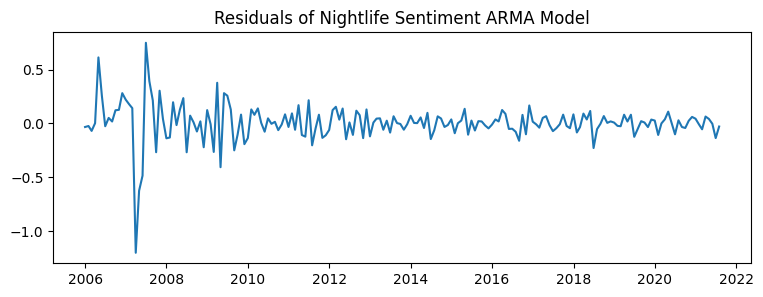

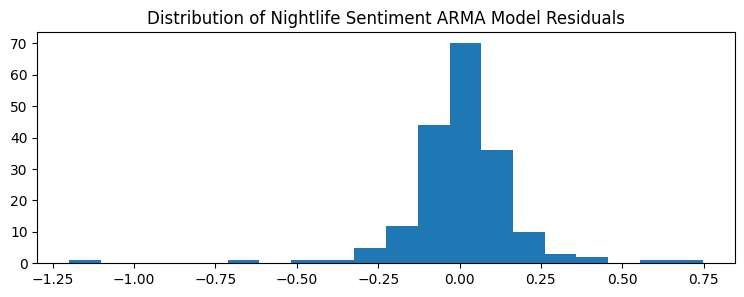

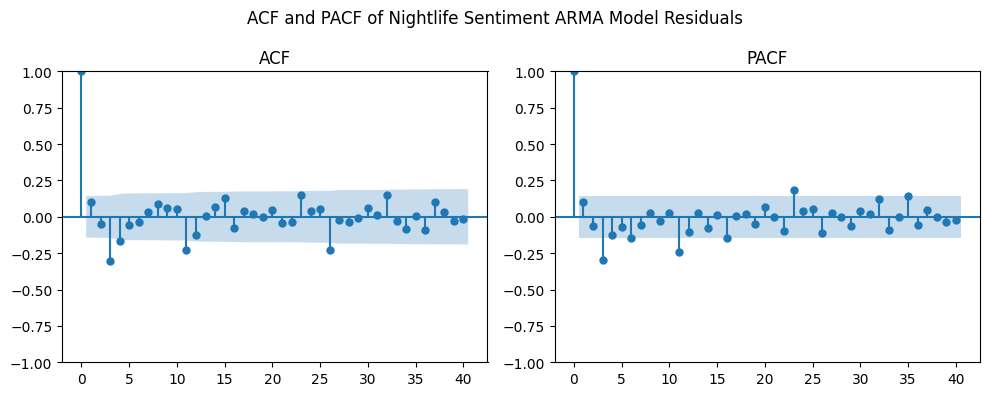

In [22]:
# model residuals

plt.figure(figsize=(9, 3))
plt.plot(nightlife_model.resid)
plt.title('Residuals of Nightlife Sentiment ARMA Model')
plt.show()

plt.figure(figsize=(9, 3))
plt.hist(nightlife_model.resid, bins=20)
plt.title('Distribution of Nightlife Sentiment ARMA Model Residuals')
plt.show()

acf_and_pacf_plots(nightlife_model.resid, title='ACF and PACF of Nightlife Sentiment ARMA Model Residuals')

In [23]:
# save model

joblib.dump(nightlife_model, 'models/nightlife_arma.pkl')

['models/nightlife_arma.pkl']

#### Breakfast & brunch sentiment

In [24]:
# fit model

breakfast_brunch_model = fit_arma_model(breakfast_brunch_residual_diff)

c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Pr

ARMA(0,0) - AIC:-154.2156868795308
ARMA(0,1) - AIC:-256.45731087396933


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


ARMA(0,2) - AIC:-253.36829404515117
ARMA(1,0) - AIC:-178.4988230581338


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Pr

ARMA(1,1) - AIC:-255.61726228949692


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizad

ARMA(1,2) - AIC:-255.8397756449035
ARMA(2,0) - AIC:-197.4029120918545


c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizad

ARMA(2,1) - AIC:-258.51551225289785
ARMA(2,2) - AIC:-251.61382784242596
Best ARMA model order: (2, 1) with AIC: -258.51551225289785


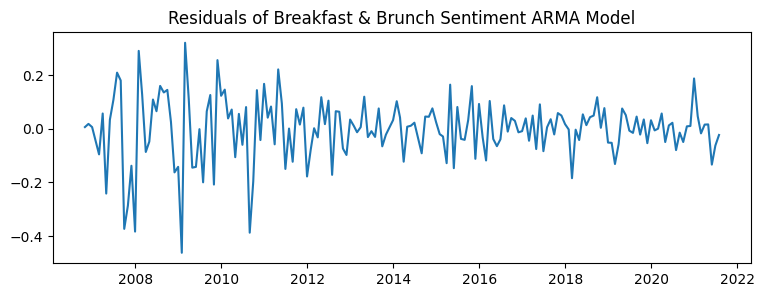

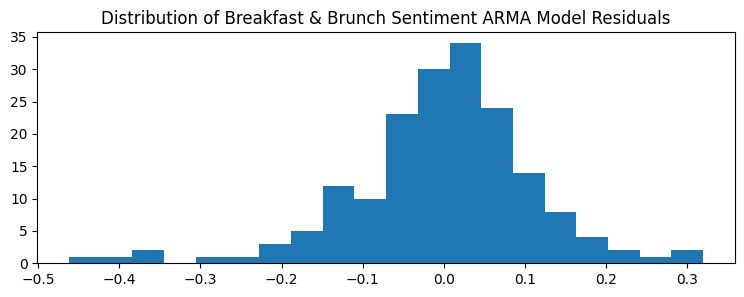

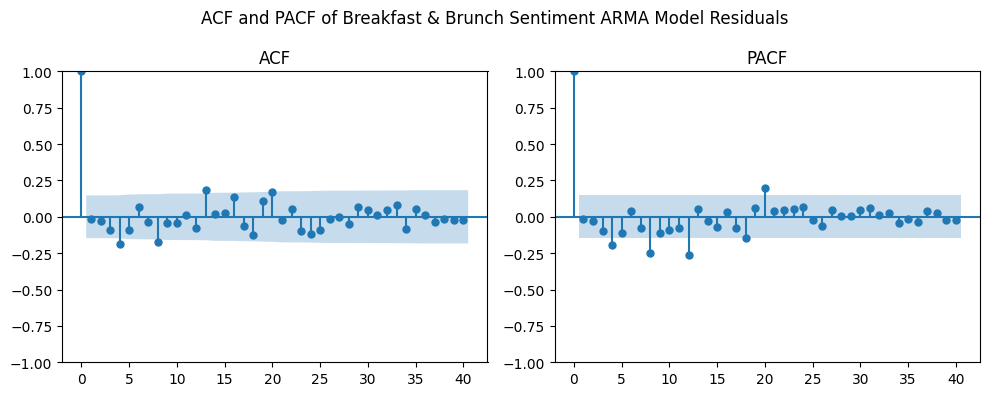

In [25]:
# model residuals

plt.figure(figsize=(9, 3))
plt.plot(breakfast_brunch_model.resid)
plt.title('Residuals of Breakfast & Brunch Sentiment ARMA Model')
plt.show()

plt.figure(figsize=(9, 3))
plt.hist(breakfast_brunch_model.resid, bins=20)
plt.title('Distribution of Breakfast & Brunch Sentiment ARMA Model Residuals')
plt.show()

acf_and_pacf_plots(breakfast_brunch_model.resid, title='ACF and PACF of Breakfast & Brunch Sentiment ARMA Model Residuals')

In [26]:
# save model

joblib.dump(breakfast_brunch_model, 'models/breakfast_brunch_arma.pkl')

['models/breakfast_brunch_arma.pkl']

### ARIMA-X modelling

In [27]:
def covid_event(date):
    '''
    Check if date is within COVID-19 event period
    '''
    start_date = pd.to_datetime('2020-01-31')
    end_date = pd.to_datetime('2022-12-31')
    return start_date <= date <= end_date

In [28]:
# create exogenous variables (COVID)

negative_exog_variables = pd.DataFrame(index=negative_reviews_per_month.index)
neutral_exog_variables = pd.DataFrame(index=neutral_reviews_per_month.index)
positive_exog_variables = pd.DataFrame(index=positive_reviews_per_month.index)

negative_exog_variables['covid'] = 0
neutral_exog_variables['covid'] = 0
positive_exog_variables['covid'] = 0

for date in negative_exog_variables.index:
    if covid_event(date):
        negative_exog_variables.loc[date, 'covid'] = 1

for date in neutral_exog_variables.index:
    if covid_event(date):
        neutral_exog_variables.loc[date, 'covid'] = 1
        
for date in positive_exog_variables.index:
    if covid_event(date):
        positive_exog_variables.loc[date, 'covid'] = 1

In [29]:
# order values

p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

In [30]:
def fit_arimax_model(time_series, exog_variables, p_values=p_values, d_values=d_values, q_values=q_values):
    '''
    Fit ARIMAX model to time series data using AICc
    '''
    best_aic = float("inf")
    best_order = None
    best_model = None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(time_series, order=(p, d, q), exog=exog_variables)
                    model_fit = model.fit()
                    aic = model_fit.aic
                    print(f'ARIMAX({p},{d},{q}) - AIC:{aic}')
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)
                        best_model = model_fit
                except Exception as e:
                    print(f'Error fitting ARIMAX({p},{d},{q}): {e}')
                    continue
    print(f'Best ARIMAX model order: {best_order} with AIC: {best_aic}')
    return best_model

#### Negative reviews

In [31]:
# fit model

negative_arimax = fit_arimax_model(negative_reviews_per_month, negative_exog_variables)

Error fitting ARIMAX(0,0,0): SARIMAX models require univariate `endog`. Got shape (186, 5).
Error fitting ARIMAX(0,0,1): SARIMAX models require univariate `endog`. Got shape (186, 5).
Error fitting ARIMAX(0,0,2): SARIMAX models require univariate `endog`. Got shape (186, 5).
Error fitting ARIMAX(0,1,0): SARIMAX models require univariate `endog`. Got shape (186, 5).
Error fitting ARIMAX(0,1,1): SARIMAX models require univariate `endog`. Got shape (186, 5).
Error fitting ARIMAX(0,1,2): SARIMAX models require univariate `endog`. Got shape (186, 5).
Error fitting ARIMAX(1,0,0): SARIMAX models require univariate `endog`. Got shape (186, 5).
Error fitting ARIMAX(1,0,1): SARIMAX models require univariate `endog`. Got shape (186, 5).
Error fitting ARIMAX(1,0,2): SARIMAX models require univariate `endog`. Got shape (186, 5).
Error fitting ARIMAX(1,1,0): SARIMAX models require univariate `endog`. Got shape (186, 5).
Error fitting ARIMAX(1,1,1): SARIMAX models require univariate `endog`. Got shap

c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Pr

In [32]:
# save model

joblib.dump(negative_arimax, 'models/negative_arimax.pkl')

['models/negative_arimax.pkl']

#### Neutral reviews

In [33]:
# fit model

neutral_arimax = fit_arimax_model(neutral_reviews_per_month, neutral_exog_variables)

Error fitting ARIMAX(0,0,0): SARIMAX models require univariate `endog`. Got shape (198, 5).
Error fitting ARIMAX(0,0,1): SARIMAX models require univariate `endog`. Got shape (198, 5).
Error fitting ARIMAX(0,0,2): SARIMAX models require univariate `endog`. Got shape (198, 5).
Error fitting ARIMAX(0,1,0): SARIMAX models require univariate `endog`. Got shape (198, 5).
Error fitting ARIMAX(0,1,1): SARIMAX models require univariate `endog`. Got shape (198, 5).
Error fitting ARIMAX(0,1,2): SARIMAX models require univariate `endog`. Got shape (198, 5).
Error fitting ARIMAX(1,0,0): SARIMAX models require univariate `endog`. Got shape (198, 5).
Error fitting ARIMAX(1,0,1): SARIMAX models require univariate `endog`. Got shape (198, 5).
Error fitting ARIMAX(1,0,2): SARIMAX models require univariate `endog`. Got shape (198, 5).
Error fitting ARIMAX(1,1,0): SARIMAX models require univariate `endog`. Got shape (198, 5).
Error fitting ARIMAX(1,1,1): SARIMAX models require univariate `endog`. Got shap

c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Pr

In [34]:
# save model

joblib.dump(neutral_arimax, 'models/neutral_arimax.pkl')

['models/neutral_arimax.pkl']

#### Positive reviews

In [35]:
# fit model

positive_arimax = fit_arimax_model(positive_reviews_per_month, positive_exog_variables)

Error fitting ARIMAX(0,0,0): SARIMAX models require univariate `endog`. Got shape (201, 5).
Error fitting ARIMAX(0,0,1): SARIMAX models require univariate `endog`. Got shape (201, 5).
Error fitting ARIMAX(0,0,2): SARIMAX models require univariate `endog`. Got shape (201, 5).
Error fitting ARIMAX(0,1,0): SARIMAX models require univariate `endog`. Got shape (201, 5).
Error fitting ARIMAX(0,1,1): SARIMAX models require univariate `endog`. Got shape (201, 5).
Error fitting ARIMAX(0,1,2): SARIMAX models require univariate `endog`. Got shape (201, 5).
Error fitting ARIMAX(1,0,0): SARIMAX models require univariate `endog`. Got shape (201, 5).
Error fitting ARIMAX(1,0,1): SARIMAX models require univariate `endog`. Got shape (201, 5).
Error fitting ARIMAX(1,0,2): SARIMAX models require univariate `endog`. Got shape (201, 5).
Error fitting ARIMAX(1,1,0): SARIMAX models require univariate `endog`. Got shape (201, 5).
Error fitting ARIMAX(1,1,1): SARIMAX models require univariate `endog`. Got shap

c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\Utilizador\AppData\Local\Pr

In [36]:
# save model

joblib.dump(positive_arimax, 'models/positive_arimax.pkl')

['models/positive_arimax.pkl']